In [2]:
%matplotlib inline
from imports import *
minorLocator   = MultipleLocator(2)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

# Skip this part until the start of the analysis
### Load installed packages and Load Time and Version lag and save them into one dataframe

In [2]:
packages = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['package','version','image','release','last_updated','type'], dtype=object)
packages.shape

(46272487, 6)

In [2]:
lag = pd.read_csv('../../data/for_analysis/tv_lag_ideal.csv', dtype=object)
lag = lag.query('last_updated != "None"').copy()
lag.head(2)

,package,version,archive,last_updated,ideal,tlag,vlag
0,0ad,0.0.21-2,stretch,2018-12-10,0.0.21-2,0,0.0
1,0ad-data,0.0.21-1,stretch,2018-12-10,0.0.21-1,0,0.0


In [4]:
packages = (packages
            .merge(lag
                   .rename(columns={'archive':'release'}),
                   on = ['package','version','last_updated','release'],
                   how = 'left'
                  )
           )
packages.shape

(46272487, 9)

In [5]:
packages.to_csv('../../data/for_analysis/images_tv_lag.csv', index=False)

# Start the analysis
# Load the version and time lag found in Docker images

In [3]:
packages = pd.read_csv('../../data/for_analysis/images_tv_lag.csv',
                      usecols=['image','release','type','last_updated','vlag','tlag'])
packages.shape

(46272487, 6)

In [4]:
release_map={'jessie':'Oldstable',
             'stretch':'Stable',
             'buster':'Testing'}
type_map={'o':'official',
          'c':'community'}

## Let's check the number of installed and outdated packages

In [5]:
num_packs = (packages
             .groupby(['image','release','type','last_updated'])
             .count()[['tlag']]
             .merge(
                 packages
                 .query('vlag > 0')
                 .groupby(['image','release','type','last_updated'])
                 .count()[['vlag']],
                 left_index = True,
                 right_index = True,
                 how = 'left'
             ))

In [6]:
num_packs = (num_packs
             .reset_index()
             .rename(columns={'vlag':'outdated','tlag':'all'})
            )

In [7]:
num_packs = num_packs.query('last_updated != "None"').copy()

In [8]:
num_packs['last_updated'] = pd.to_datetime(num_packs['last_updated'])
num_packs.shape

(140496, 6)

In [9]:
num_packs = num_packs.replace({'type': type_map})
num_packs = num_packs.replace({'release': release_map})

In [10]:
num_packs.fillna(0, inplace=True)

In [11]:
num_packs['outProp'] = num_packs['outdated']/num_packs['all']

In [12]:
num_packs.query('type == "community"')['all'].describe()['std']

126.02193041516222

In [13]:
num_packs.query('type == "official"')['all'].describe()['std']

103.19809760099575

### Number of all installed packages  per image

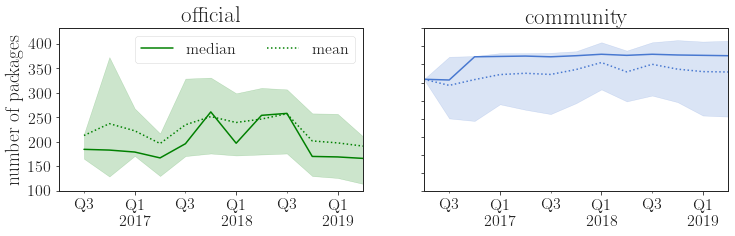

In [70]:
# INSTALLED PACKAGES
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(num_packs.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['all'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='',
        ylabel='number of packages',
        title=genre,    )
    
    ax.xaxis.set_minor_locator(minorLocator)
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='black', label='median'),
                   Line2D([0], [0], linestyle='--', color='black', label='mean')]
    plt.yticks(pd.np.arange(0, 500, 50))
    ax.legend(prop={'size': 16}, ncol=2) #handles=legend_elements, 
ax.legend('').remove() #handles=legend_elements, 


### Number of all outdated packages per image

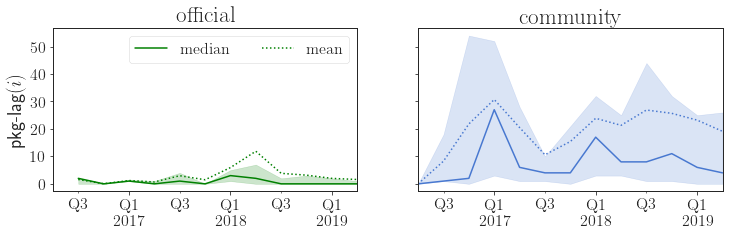

In [71]:
# OUTDATED PACKAGES
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(num_packs.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1q'))['outdated'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='',
        ylabel='$\pkglag(i)$',
        title=genre,    )
    ax.xaxis.set_minor_locator(minorLocator)

    plt.yticks(pd.np.arange(0, 60, 10))
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) #handles=legend_elements, 
ax.legend('').remove()

In [15]:
print(num_packs.query('type=="official"').outdated.median(),
      num_packs.query('type=="community"').outdated.median())

0.0 7.0


In [16]:
num_packs.outdated.median()

6.0

In [22]:
# Mann-whitney u test
import effect_size
print(effect_size.cliffsDelta(num_packs.query('type=="official"').outdated, 
        num_packs.query('type=="community"').outdated))

d=-0.5064030126425301
True


In [13]:
# Mann-whitney u test
print(scipy.stats.mannwhitneyu(num_packs.query('type=="community"').outdated, 
        num_packs.query('type=="official"').outdated))

MannwhitneyuResult(statistic=302026759.5, pvalue=0.0)


In [15]:
# Mann-whitney u test
import effect_size
print(effect_size.cliffsDelta(num_packs.query('type=="official"').outdated, 
        num_packs.query('type=="community"').outdated))

d=-0.5064030126425301
True


### Number of outdated packages per image grouped by Debian distribution

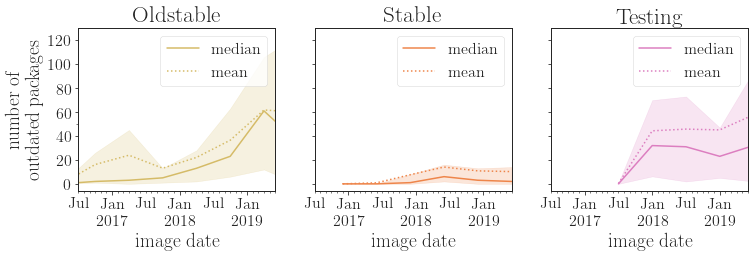

In [51]:
### Number of all outdated packages per image
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['Oldstable','Stable','Testing']):
    size=[12,20,70]
    df_=(num_packs.
         query('release=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='6M'))['outdated'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='image date',
        ylabel='number of \noutdated packages',
        title=genre,
        xlim=date_period)
    ax.legend(prop={'size': 16, 'weight':'bold'})
    plt.yticks(pd.np.arange(0, 130, 20))

In [28]:
# Compute R²
for genre in ['official','community']:
    print('Median:', num_packs.query('type=="{}"'.format(genre)).outProp.mean()*100)

Median: 1.8699969608468778
Median: 6.538937725225791


In [16]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(num_packs.query('release=="'+x[0]+'"').outdated, 
            num_packs.query('release=="'+x[1]+'"').outdated))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=1397264552.5, pvalue=0.0)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=96683582.5, pvalue=9.710184023079058e-25)
['Stable', 'Testing'] MannwhitneyuResult(statistic=87467563.5, pvalue=0.0)


In [18]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(num_packs.query('release=="'+x[0]+'"').outdated, 
            num_packs.query('release=="'+x[1]+'"').outdated))

d=0.37981437050517936
['Oldstable', 'Stable'] True
d=-0.09788869877109384
['Oldstable', 'Testing'] False
d=-0.4400310734753538
['Stable', 'Testing'] True


### Analysis of Time lag, considering the max as aggregation

In [17]:
start_time = time.time()
tlag_image=(packages
            .query('tlag != 0')
            .copy()
            [['image','release','type','last_updated','tlag']]
            .groupby(['image','release','type','last_updated'])
            .agg('max')
            .reset_index()
           )
print("--- %s seconds ---" % (time.time() - start_time))# We aggregate version lag by max
tlag_image.shape

--- 2.110192060470581 seconds ---


(135612, 5)

In [18]:
tlag_image = tlag_image.replace({'release': release_map})
tlag_image = tlag_image.replace({'type': type_map})
tlag_image = tlag_image.query('last_updated != "None"').copy()
tlag_image['last_updated'] = pd.to_datetime(tlag_image['last_updated'])

In [19]:
tlag_image.fillna(0, inplace=True)

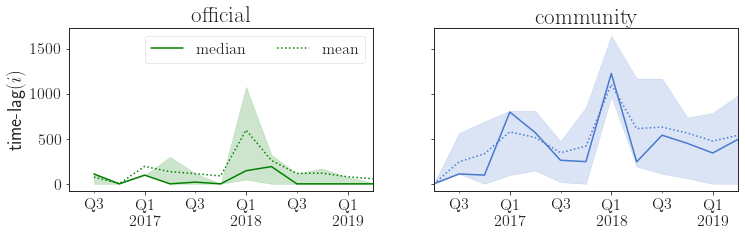

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(tlag_image.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1q'))['tlag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='',
        ylabel=r'$\timelag(i)$',
        title=genre,    )
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) #handles=legend_elements, 
ax.legend('').remove()    

In [21]:
tlag_image.tlag.median()

399.0

In [10]:
# Compute R²
for genre in ['official','community']:
    df_ = tlag_image.query('type=="{}"'.format(genre))
    print('Median:', df_.tlag.median())

Median: 0.0
Median: 466.0


In [12]:
# Mann-whitney u test
print(scipy.stats.mannwhitneyu(tlag_image.query('type=="community"').tlag, 
        tlag_image.query('type=="official"').tlag))

MannwhitneyuResult(statistic=273454516.0, pvalue=0.0)


In [14]:
# Mann-whitney u test
import effect_size
print(effect_size.cliffsDelta(tlag_image.query('type=="official"').tlag, 
        tlag_image.query('type=="community"').tlag))

d=-0.5027467492266908
True


## Considering the Debian release

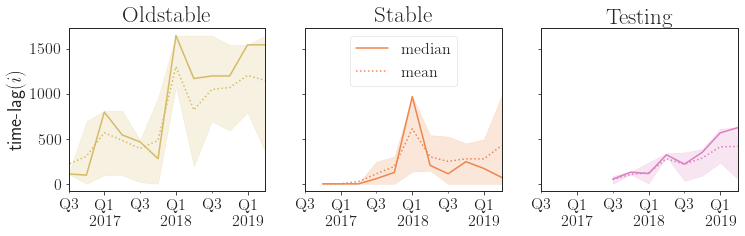

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['Oldstable','Stable','Testing']):
    size=[12,20,70]
    df_=(tlag_image.
         query('release=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['tlag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='',
        ylabel=r'$\timelag(i)$',
        title=genre,    
        xlim=date_period)
    ax.xaxis.set_minor_locator(minorLocator)
    if index==1:
        ax.legend(loc='upper center', prop={'size': 16}, ncol=1) #handles=legend_elements,
    else:
        ax.legend('').remove()


In [17]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(tlag_image.query('release=="'+x[0]+'"').tlag, 
            tlag_image.query('release=="'+x[1]+'"').tlag))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=1047551690.5, pvalue=0.0)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=54288605.5, pvalue=0.0)
['Stable', 'Testing'] MannwhitneyuResult(statistic=134270201.5, pvalue=3.966741469750341e-27)


In [16]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(tlag_image.query('release=="'+x[0]+'"').tlag, 
            tlag_image.query('release=="'+x[1]+'"').tlag))

d=0.5000492173082322
['Oldstable', 'Stable'] True
d=0.46940641095591606
['Oldstable', 'Testing'] True
d=-0.10089834296623523
['Stable', 'Testing'] False


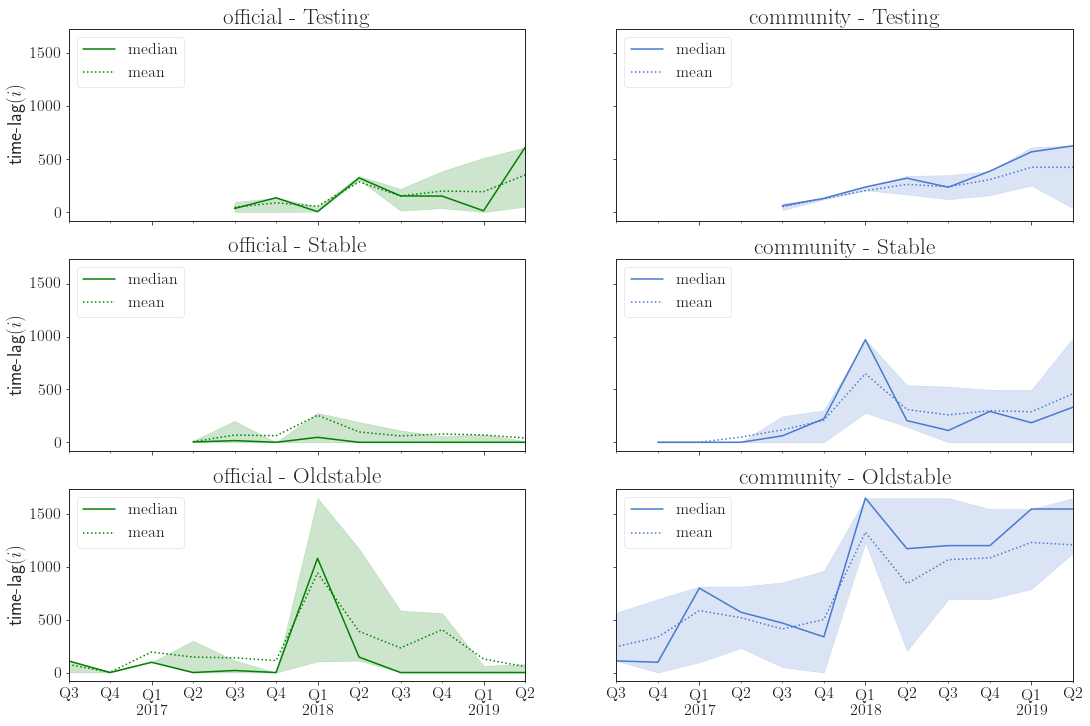

In [86]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(18,12)
for j, release in enumerate(['Testing','Stable','Oldstable']):
    for index, genre in enumerate(['official','community']):
        df_=(tlag_image.
             query('type=="{}" and release =="{}"'.format(genre, release)).
             groupby(pd.Grouper(key='last_updated', freq='1q'))['tlag'].
             describe()[['mean', '25%', '50%', '75%']] 
            )

        df_tmp=df_
        df_tmp['50%'].rename('median').plot(ax=axes[j][index], color=colors[genre])
        ax=df_tmp['mean'].plot(ax=axes[j][index],style=':',color=colors[genre])
        ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])

        ax.set(
            xlabel='',
            ylabel=r'$\timelag(i)$',
            title=genre+' - '+release,        
            xlim=date_period)
        ax.legend(loc='upper center',  prop={'size': 16, 'weight':'bold'})


### Analysis of Version lag, considering the sum as aggregation

In [ ]:
# We aggregate version lag by sum
vlag_image=(packages[['image','release','type','last_updated','vlag']]
            .groupby(['image','release','type','last_updated'])
            .agg('sum')
            .reset_index()
           )
vlag_image.shape

In [24]:
vlag_image = vlag_image.replace({'release': release_map})
vlag_image = vlag_image.replace({'type': type_map})
vlag_image = vlag_image.query('last_updated != "None"').copy()
vlag_image['last_updated'] = pd.to_datetime(vlag_image['last_updated'])

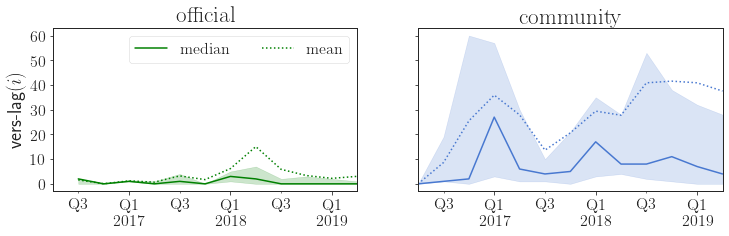

In [25]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(vlag_image.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1q'))['vlag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='',
        ylabel=r'$\versionlag(i)$',
        title=genre,    )
    plt.yticks(pd.np.arange(0, 61, 10))
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) #handles=legend_elements, 
ax.legend('').remove()

In [10]:
# Compute R²
for genre in ['official','community']:
    df_ = vlag_image.query('type=="{}"'.format(genre))
    print('Median:', df_.vlag.median())

Median: 0.0
Median: 7.0


In [26]:
# Mann-whitney u test
import effect_size
print(effect_size.cliffsDelta(vlag_image.query('type=="official"').vlag, 
        vlag_image.query('type=="community"').vlag))

d=-0.5138648628962172
True


In [27]:
vlag_image.vlag.median()

6.0

In [37]:
num_packs.query('release=="Testing"').outdated.median()

25.0

In [36]:
vlag_image.query('release=="Testing"').vlag.median()

43.0

### Considering the debian release

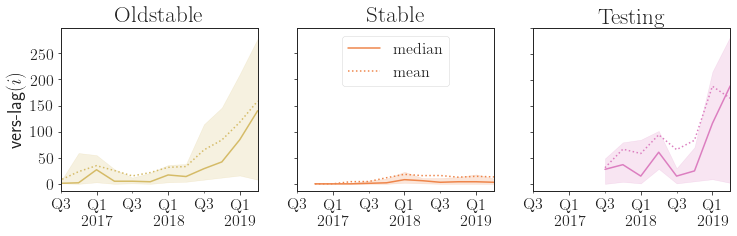

In [102]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['Oldstable','Stable','Testing']):
    size=[12,20,70]
    df_=(vlag_image.
         query('release=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['vlag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    ax.set(
        xlabel='',
        ylabel=r'$\versionlag(i)$',
        title=genre,
        xlim=date_period)
    ax.xaxis.set_minor_locator(minorLocator)
    if index==1:
        ax.legend(loc='upper center', prop={'size': 16}, ncol=1) #handles=legend_elements,
    else:
        ax.legend('').remove()    
    plt.yticks(pd.np.arange(0, 301, 50))

In [20]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(vlag_image.query('release=="'+x[0]+'"').vlag, 
            vlag_image.query('release=="'+x[1]+'"').vlag))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=1421191654.5, pvalue=0.0)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=85649944.0, pvalue=1.3904228565386457e-97)
['Stable', 'Testing'] MannwhitneyuResult(statistic=80764225.5, pvalue=0.0)


In [21]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(vlag_image.query('release=="'+x[0]+'"').vlag, 
            vlag_image.query('release=="'+x[1]+'"').vlag))

d=0.36919415918635196
['Oldstable', 'Stable'] True
d=-0.20083864877449134
['Oldstable', 'Testing'] True
d=-0.4829459648223829
['Stable', 'Testing'] True


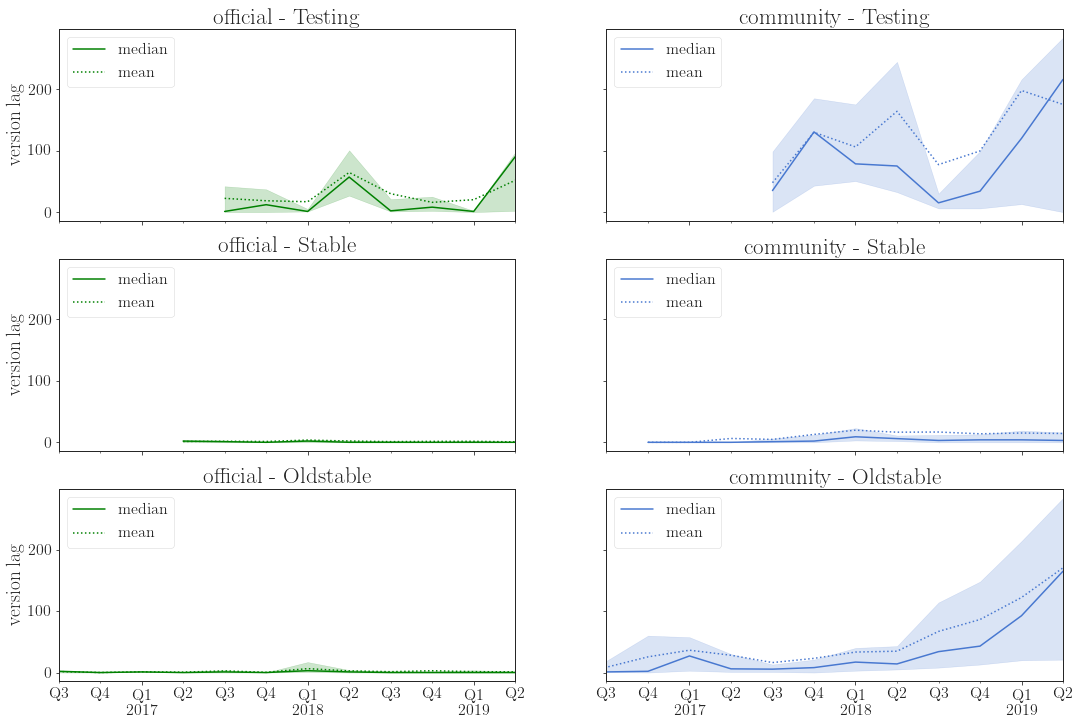

In [53]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(18,12)
for j, release in enumerate(['Testing','Stable','Oldstable']):
    for index, genre in enumerate(['official','community']):
        df_=(vlag_image.
             query('type=="{}" and release =="{}"'.format(genre, release)).
             groupby(pd.Grouper(key='last_updated', freq='1q'))['vlag'].
             describe()[['mean', '25%', '50%', '75%']] 
            )

        df_tmp=df_
        df_tmp['50%'].rename('median').plot(ax=axes[j][index], color=colors[genre])
        ax=df_tmp['mean'].plot(ax=axes[j][index],style=':',color=colors[genre])
        ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])

        ax.set(
            xlabel='',
            ylabel='version lag',
            title=genre+' - '+release,        
            xlim=date_period)
        ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

# Merge all prepared dataframse into one dataframe, to be reused later

In [6]:
all_lags = pd.read_csv('../../data/for_analysis/image_lags.csv', dtype=object)
all_lags.shape

(140496, 9)

In [31]:
all_lags.drop('tlag', axis=1, inplace=True)

In [32]:
all_lags = (all_lags
            .merge(tlag_image[['image','tlag']],
                   on = 'image',
                   how='left'
                  )
           )
all_lags.fillna(0, inplace=True)
all_lags.shape

(140496, 8)

In [11]:
all_lags = (all_lags
            .merge(vlag_image[['image','vlag']],
                   on = 'image',
                   how='left'
                  )
           )
all_lags.shape

(140496, 8)

In [36]:
all_lags = (all_lags
            .merge(num_packs[['image','outdated']],
                   on = 'image',
                   how='left'
                  )
           )
all_lags.shape

(140496, 9)

### let's add the number of installed packages to the dataframe

In [3]:
packages = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['image','package'], dtype=object)
packages.shape

(46272487, 2)

In [4]:
packages = packages.groupby('image').count().reset_index()

In [5]:
packages.rename(columns={'package':'packages'}, inplace=True)

In [8]:
all_lags = (all_lags
            .merge(packages,
                   on = 'image',
                   how='left'
                  )
           )
all_lags.fillna(0, inplace=True)
all_lags.shape

(140496, 10)

In [10]:
all_lags.to_csv('../../data/for_analysis/image_lags.csv', index=False)